#  **ICT303 - Assignment 1**

In this homework, you will build a model for predicting house prices. For this, you will use real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

Your task is to:
1. Develop a better model to reduce the prediction error. You can find some hints on the last section. 
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result. 

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

In [1]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import numpy as np
import torch
import pandas as pd

Download the train and test dataset from [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) (in the Data tab). You will need to sign it to access the data. These are two Comma Separated Values (CSV) files containing training and test data respectively we use Pandas.

Save them into your google drive. To read them into your code, use the following command (from panda)

### Running code to generalize access to housing data and packages

In [2]:
import os
import importlib

def install_package(package):
    try:
        importlib.import_module(package)
    except ImportError:
        import sys
        !{sys.executable} -m pip install {package}

def is_running_in_colab():
    try:
        from google.colab import _ipython as ip
        return True
    except ImportError:
        return False

try:
  if is_running_in_colab():
    print("Running in Google Colab")
  else:
    print("Running in Jupyter or VSCode")

  import requests
  url = 'https://raw.githubusercontent.com/joccing/ICT303-assignment1/master/config.py'
  r = requests.get(url, allow_redirects=True)
  open('config.py', 'wb').write(r.content)

except ModuleNotFoundError:
  pass

from config import *
config_data()

Running in Jupyter or VSCode
Finished!


In [3]:
try:
    import pandas as pd
except ImportError:
    # If pandas is not installed, install it
    install_package('pandas')
    import pandas as pd

train_data = pd.read_csv('data/train.csv')
test_data  = pd.read_csv('data/test.csv')
assert train_data.shape == (1460,81)
assert test_data.shape == (1459, 80)
print('Loaded and verified data!')

Loaded and verified data!


The training data set includes 1,460 examples, 80 features, and 1 label. The test data contains 1,459 examples and 80 features. You can check the content of the files by opening them in Excel or by using the following two commands

In [4]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [6]:
#all features except the first (Id) and the last (SalePrice) are input features
#test_data.iloc does not need to -1 because it does not have SalePrice (ground-truth label)
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## **2. Data Preprocessing**

As stated above, we have a wide variety of datatypes. Before we feed it into a  network we need to perform some amount of processing. 

Let's start with the **numerical features**. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

This process is called **normalization** or **standardisation**. The reason for normalizing the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

Write below the code that does the normalization for each numerical features:

In [7]:
# Normalize the numerical features
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

# Set missing values to 0
all_features = all_features.fillna(0)


Next we deal with the **discrete values**. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [8]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
#hence the number of features changed from 79 to 353
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 353)

You can see that this conversion increases the number of features from 79 to 353. 

Finally, via the `values` attribute we can extract the NumPy format from the Pandas dataframe and prepare them for training.

In [9]:
#Store the number of rows in your training data (which is the number of samples in your training dataset) into the variable n_train.
n_train = train_data.shape[0]

# the train feature are in all_features. slicing the DataFrame all_features to select only the first n_train rows + Convert to tensor
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32))

# the test feature are in all_features,taking everything after the first n_train rows + Convert to tensor
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32))

# the train labels are in train_data.SalePrice.values.
# Select the SalePrice column from the train_data DataFrame and getting its underlying numpy array. 
# This array is then converted to a PyTorch tensor using torch.tensor(). 
# The reshape((-1, 1)) method call is reshaping the tensor to have one column and as many rows as necessary (which would be equal to the number of training examples). 
# The reason for this reshaping is that PyTorch's loss functions (such as MSELoss used for regression problems) expect the target tensor to have this shape.
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float32).reshape((-1, 1))

#print the shapes of the tensors for training and testing data to check if they are correct
print("Checking the shapes of the tensors for training and testing data:")
print("Training data = ",train_features.shape)
print("Testing data = ",test_features.shape)
print("Training label = ",train_labels.shape)

Checking the shapes of the tensors for training and testing data:
Training data =  torch.Size([1460, 353])
Testing data =  torch.Size([1459, 353])
Training label =  torch.Size([1460, 1])


## **3. Training**

### **3.1. Loss function**
To get started, train an MLP model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

To this end, use the codes you developed in Lab 4. However, we may need to test with a better loss function to achieve better results. In fact, house prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy between the predicted price and the correct price in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in the Kaggle competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

### Start with implmenting the MLP architecture

In [10]:
#general note: the data is already normalized, so no need to do it again
#the data is already converted to a pytorch tensor, so no need to do it again
#the data is already split into train and test, so no need to do it again
#Input layer: 353 neurons = 353 input features (displayed in all features.shape above)
#Hidden layer 1: 256 neurons
#Hidden layer 2: 128 neurons
#Hidden layer 3: 64 neurons
#Output layer: 1 neuron = output sales price value

from torch import nn

#manually create the rmsle loss function
def rmsle(y_pred, y_true):
  assert len(y_true) == len(y_pred)
  y_pred = torch.clamp(y_pred, min=0)  # ensure predictions are non-negative
  return torch.sqrt(torch.nn.functional.mse_loss(torch.log1p(y_pred), torch.log1p(y_true)))


#implement the MLP_A1 class
class MLP_A1 (nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, inputSize=train_features.shape[1], outputSize=1, lr=0.01, dropout=0.2):      
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(inputSize, 256),
        nn.ReLU(),
        nn.Dropout(dropout), # Add dropout after ReLU activation, prevent overfitting
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(64, outputSize),
    )
    # Setting the learning rate
    self.lr = lr

  ## The forward step
  def forward(self, X):
    # Computes the output given the input X
    return self.layers(X)

  ## The loss function - Here, we will use Root Mean Squared Logarithmic Error (RMSLE) created above
  def loss(self, y_hat, y):
    return rmsle(y_hat, y)

  ## The optimization algorithm
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), self.lr)
    

### **3.2. k-Fold Cross-Validation**

To get good performance, you usually need to select the network architecture. This includes the type of network, the number of layers, the number of hidden neurons in each layer, the learning rate, the batch size, etc. These are called **hyper paramters**.

However, it is difficult to know which configuration of the hyperparameters above would achieve the best performance. Thus in practice, we need to try multiple configurations (i.e., choices of the hyperparameters), evaluate the performance of each configuration, and pick the one that gives the best performance.

To assess the performance of a given configuratation, you need to take the training set and randomly divide it into two subsets:
- one subset will be called training set (usually 80% of the entire data set),
- the second one will be called validation set (usually 20% of the entire data set.

Then, train your model on the training set and test it on the validation set. Repeat this process $k$ times and average the performance over all the run. This will then be the performance of this configuration. This process is called **$k-$fold cross validation**. $k$ is usually chosen to be $5$ or $10$. 

Run this procedure for each of the configurations you defined and pick the one that gives the best performance.

To use it, first we need a function that returns the i-th fold of the data in a k-fold cross-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. 

Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [11]:
#use to slice dataset into training & validation sets based on current fold (i)
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            #changing from pd.concat (provided) to torch.concat to concatenate tensors
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [23]:
def train_model(model, X, y, batch_size, optimizer):
    # Create a DataLoader to handle batching of the data
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_loss = 0
    # Iterate over batches of data
    for X_batch, y_batch in dataloader:
        # Set the model in training mode
        model.train()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = model.loss(outputs, y_batch)

        # Backward pass and updates
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.shape[0]

    # Return the average loss over all samples
    return total_loss / len(X)



def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, batch_size, dropout=0.2):
    
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        #get the i-th fold of the data in the k-fold dataset
        data = get_k_fold_data(k, i, X_train, y_train)

        #set up the MLP_A1 model
        model = MLP_A1(lr=learning_rate, dropout=dropout)

        #set up the optimizer
        optimizer = model.configure_optimizers()

        # train on daata and return the train and validation errors in train_ls and valid_ls, respectively
        for epoch in range(num_epochs):
            train_features, train_labels = data[0], data[1]
            valid_features, valid_labels = data[2], data[3]

            # train on data and return the train loss
            train_loss = train_model(model, train_features, train_labels, batch_size, optimizer)
            
            # Use the model for prediction
            model.eval() #set the model in evaluation mode
            with torch.no_grad():
                valid_predictions = model(valid_features)
            
            # Compute validation loss
            valid_loss = rmsle(valid_predictions, valid_labels)

            print(f'fold {i+1}, epoch {epoch+1}, train rmse: {train_loss:.6f}, valid rmse: {valid_loss:.6f}')
        train_l_sum += train_loss
        valid_l_sum += valid_loss.item()  # get a Python number from a tensor containing a single value
        
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_l_sum, valid_l_sum))
        
    return train_l_sum / k, valid_l_sum / k

Finding a good choice of the hyperparameters can take quite some time, depending on how many things one wants to optimize over. Within reason the $k$-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

#### Let's use k-fold to find a good batch sizes and learning rate

In [13]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
num_epochs = 300
k = 5  # perform 5-fold cross-validation

best_avg_valid_loss = float('inf')
best_lr = None
best_bs = None

#we iterate through the learning rates and batch sizes to find the best combination
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Trying learning rate {lr} and batch size {bs}")
        avg_train_loss, avg_valid_loss = k_fold(k, train_features, train_labels, num_epochs, lr, bs)
        print(f"Average training loss: {avg_train_loss}, average validation loss: {avg_valid_loss}")
        if avg_valid_loss < best_avg_valid_loss:
            best_avg_valid_loss = avg_valid_loss
            best_lr = lr
            best_bs = bs

print(f"Best learning rate: {best_lr}, best batch size: {best_bs}, with validation loss: {best_avg_valid_loss}")


Trying learning rate 0.1 and batch size 16
fold 1, epoch 1, train rmse: 12.028141, valid rmse: 12.040857
fold 1, epoch 2, train rmse: 12.028141, valid rmse: 12.040857
fold 1, epoch 3, train rmse: 12.028141, valid rmse: 12.040857
fold 1, epoch 4, train rmse: 12.028135, valid rmse: 8.695738
fold 1, epoch 5, train rmse: 8.670715, valid rmse: 5.294968
fold 1, epoch 6, train rmse: 5.296550, valid rmse: 3.176600
fold 1, epoch 7, train rmse: 3.169011, valid rmse: 1.660358
fold 1, epoch 8, train rmse: 1.659739, valid rmse: 0.563803
fold 1, epoch 9, train rmse: 0.576796, valid rmse: 0.484420
fold 1, epoch 10, train rmse: 0.516770, valid rmse: 1.008983
fold 1, epoch 11, train rmse: 1.026893, valid rmse: 1.376199
fold 1, epoch 12, train rmse: 1.401128, valid rmse: 1.622836
fold 1, epoch 13, train rmse: 1.640451, valid rmse: 1.782133
fold 1, epoch 14, train rmse: 1.794656, valid rmse: 1.875000
fold 1, epoch 15, train rmse: 1.896123, valid rmse: 1.914777
fold 1, epoch 16, train rmse: 1.928495, vali

### Output of epoch testing

with epoch = 10
Average training loss: 12.009834671020508, average validation loss: 12.001776885986327
Best learning rate: 0.1, best batch size: 16, with validation loss: 1.714041042327881

with epoch = 50
Average training loss: 11.580953407287598, average validation loss: 11.562812042236327
Best learning rate: 0.1, best batch size: 32, with validation loss: 0.16463427245616913

with epoch = 150
Average training loss: 11.580953407287598, average validation loss: 11.562812042236327
Best learning rate: 0.1, best batch size: 32, with validation loss: 0.16463427245616913

with epoch = 300
Average training loss: 7.508149433135986, average validation loss: 7.499252986907959
Best learning rate: 0.01, best batch size: 32, with validation loss: 0.13084464967250825

with epoch = 400
Average training loss: 6.526771068572998, average validation loss: 6.521764183044434
Best learning rate: 0.01, best batch size: 32, with validation loss: 0.13141397535800933

with epoch = 500
Average training loss: 6.125911712646484, average validation loss: 6.120782375335693
Best learning rate: 0.01, best batch size: 64, with validation loss: 0.13341183364391326

### Conclusion: Decide to use the following hyper parameter:
- epoch = 300
- learning rate = 0.01
- batch size = 32

### Testing out the different drop out value

In [16]:
# fixed Hyperparameters
k = 5
num_epochs = 300
learning_rate = 0.01
batch_size = 32

# Hyperparameters to be tuned
dropout_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# For storing results
results = []

for dropout in dropout_values:
    print(f'\nRunning k-fold with dropout = {dropout}')
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, bs)
    print(f'Average training loss: {train_l}, average validation loss: {valid_l}\n')
    results.append((dropout, train_l, valid_l))

# Find the dropout with the smallest validation loss
best_dropout, _, _ = min(results, key=lambda x: x[2])
print(f'Best dropout value: {best_dropout}')



Running k-fold with dropout = 0.0
fold 1, epoch 1, train rmse: 11.999616, valid rmse: 12.004136
fold 1, epoch 2, train rmse: 11.994723, valid rmse: 11.998096
fold 1, epoch 3, train rmse: 11.989074, valid rmse: 11.992204
fold 1, epoch 4, train rmse: 11.982288, valid rmse: 11.986442
fold 1, epoch 5, train rmse: 11.977181, valid rmse: 11.980867
fold 1, epoch 6, train rmse: 11.971572, valid rmse: 11.975464
fold 1, epoch 7, train rmse: 11.967219, valid rmse: 11.970212
fold 1, epoch 8, train rmse: 11.962719, valid rmse: 11.965117
fold 1, epoch 9, train rmse: 11.956463, valid rmse: 11.960189
fold 1, epoch 10, train rmse: 11.951297, valid rmse: 11.955373
fold 1, epoch 11, train rmse: 11.946828, valid rmse: 11.950663
fold 1, epoch 12, train rmse: 11.941404, valid rmse: 11.946031
fold 1, epoch 13, train rmse: 11.936402, valid rmse: 11.941459
fold 1, epoch 14, train rmse: 11.932360, valid rmse: 11.936921
fold 1, epoch 15, train rmse: 11.928932, valid rmse: 11.932363
fold 1, epoch 16, train rmse:

### Conclusion: Dropout value decided as 0.2.


##  **4. Predict and Submit**

Once you have figured out what a good choice of hyperparameters should be, you might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

So your task here is that once you have decided what are the best hyperparameters, train on the entire Kaggle training set, test it on the Kaggle test set, save the result as a .csv file and submit it to Kaggle. The steps are quite simple:
* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

You need to include a screenshot of your results in the assignment submission.

In [24]:
#train model with best hyperparameters using whole training set in prep for prediction
# define the model with the best hyperparameters
model = MLP_A1(inputSize=train_features.shape[1], outputSize=1, lr=0.01, dropout=0.2)

# define the optimizer
optimizer = model.configure_optimizers()

# Set the number of epochs and batch size to be used for training
num_epochs = 300
batch_size = 32

# train the model
for epoch in range(num_epochs):
    train_loss = train_model(model, train_features, train_labels, batch_size, optimizer)
    print(f'epoch {epoch+1}, train rmse: {train_loss:.6f}')



epoch 1, train rmse: 3.271302
epoch 2, train rmse: 0.282006
epoch 3, train rmse: 0.185186
epoch 4, train rmse: 0.172276
epoch 5, train rmse: 0.163567
epoch 6, train rmse: 0.163420
epoch 7, train rmse: 0.163400
epoch 8, train rmse: 0.160914
epoch 9, train rmse: 0.158997
epoch 10, train rmse: 0.158798
epoch 11, train rmse: 0.160004
epoch 12, train rmse: 0.155492
epoch 13, train rmse: 0.157747
epoch 14, train rmse: 0.155039
epoch 15, train rmse: 0.156150
epoch 16, train rmse: 0.155961
epoch 17, train rmse: 0.154599
epoch 18, train rmse: 0.151814
epoch 19, train rmse: 0.156808
epoch 20, train rmse: 0.149710
epoch 21, train rmse: 0.146198
epoch 22, train rmse: 0.149882
epoch 23, train rmse: 0.151729
epoch 24, train rmse: 0.148620
epoch 25, train rmse: 0.150205
epoch 26, train rmse: 0.148829
epoch 27, train rmse: 0.146910
epoch 28, train rmse: 0.146216
epoch 29, train rmse: 0.148768
epoch 30, train rmse: 0.146557
epoch 31, train rmse: 0.147288
epoch 32, train rmse: 0.144465
epoch 33, train r

In [30]:
# predict the prices
predictions = model(test_features).detach().numpy()
print("Raw Predictions: ", predictions, "\n\n")


# Create a DataFrame for submission
submission = pd.DataFrame()

# Assuming that your test data has an 'Id' column
submission['Id'] = test_data['Id'] # make sure to load these

# Round off to the nearest decimal as the example shows a decimal number
submission['SalePrice'] = np.round(predictions, 1)

# Write the DataFrame to a csv file
submission.to_csv('submission.csv', index=False)

print("Submission file created.")

Raw Predictions:  tensor([[118986.6562],
        [142289.7500],
        [187982.2812],
        ...,
        [164651.5000],
        [104033.0156],
        [209731.3594]]) 


Submission file created.


## **5. What you need to do in this assignment**

In this assignment, you need to come up with the best neural network that can predict the house prices. This includes:
- The choice of the network: convolutional network, MLP, a combination, ...
- Setting the hyperparameters including the number of layers and the number of neurons in each layer.
- Train it on the Kaggle train set and test it on the Kaggle test set.

You may want to consider the following **hints**:
1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?


**What to submit**
- The colab notebook that implements the solution. You can update directly this notebook, as as many sections as you want. When I run your notebook, it  should load the Kaggle data. Make sure you provide enough explanation of your work.
- A screenshot of your score on Kaggle.


### Other configuration tested:

1. MLP with 1 hidden layer
2. MLP with 2 hidden layer
3. Testing with Epoch 10, 50, 100, 200, 300, 400, 500
4. K-fold tested with learning rate and batch size same as the MLP designed in this notebook.


Screenshot of score from alternative design:
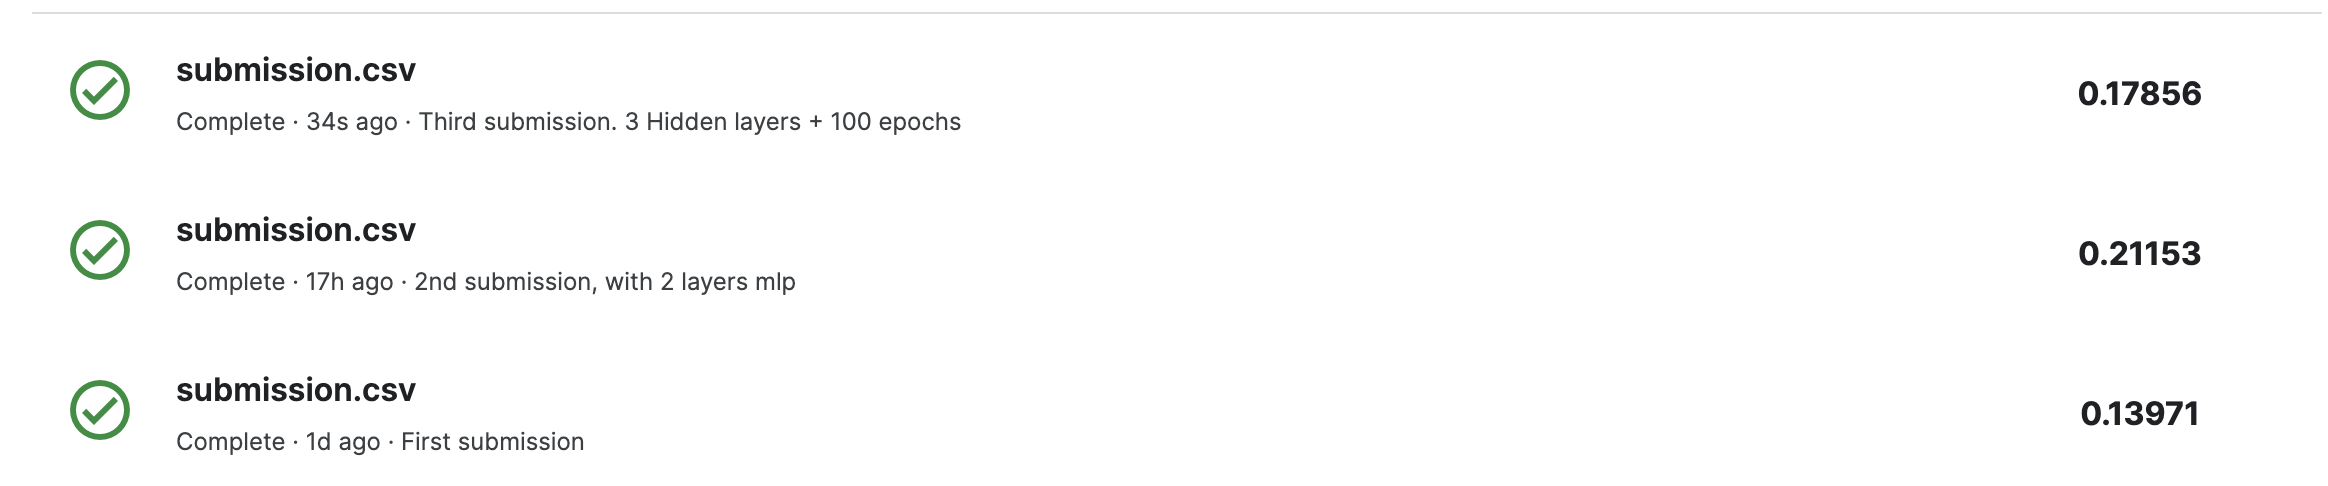